In [1]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import uproot
import os
import glob
import awkward as ak
from scipy.stats import norm
import matplotlib.ticker as ticker
plt.rcParams["xtick.top"] = True    # enable top x-ticks
plt.rcParams["ytick.right"] = True  # enable right y-ticks
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

In [2]:
data_path = "/home/haue/repositories/Masters/data/singleprotons/Al/inclbetacut/"
betacut = "/home/haue/repositories/Masters/data/gamma/Al/thresholdedbetas"
nobetacut = "/home/haue/repositories/Masters/data/gamma/Al/withbeta"
#outputdir = "/figure_output/"
## Load in all files from the datapath with the suffix mlio.root
Al_files = glob.glob(os.path.join(data_path, "*mlio.root"))
betath_files = glob.glob(os.path.join(betacut, "*mlio.root"))
beta_files = glob.glob(os.path.join(nobetacut, "*mlio.root"))


upscale = 1/0.34
scale =  4.993289447838043 # ratio between total solid angle coverage and solid angle coverage of id3 to account for lack of detection of beta particles

In [3]:

Egs1 = np.array([]);Egs2 = np.array([])
for batch in uproot.iterate(betath_files, expressions=["Eg1"],
            cut=f"(bg1) & (Eg1>0)"):
    Egs1 = np.append(Egs1, batch.Eg1)
print("Eg1 done")
for batch in uproot.iterate(betath_files, expressions=["Eg2"],
            cut=f"(bg2) & (Eg2>0)"):
    Egs2 = np.append(Egs2, batch.Eg2)

Egs1 = Egs1[~np.isnan(Egs1)]
Egs2 = Egs2[~np.isnan(Egs2)]



Egs3 = np.array([]);Egs4 = np.array([])
for batch in uproot.iterate(beta_files, expressions=["Eg1"],
            cut=f"(bg1) & (Eg1>0)"):
    Egs3 = np.append(Egs3, batch.Eg1)
print("Eg1 done")
for batch in uproot.iterate(beta_files, expressions=["Eg2"],
            cut=f"(bg2) & (Eg2>0)"):
    Egs4 = np.append(Egs4, batch.Eg2)

Egs3 = Egs3[~np.isnan(Egs3)]
Egs4 = Egs4[~np.isnan(Egs4)]



Eg1 = np.array([]);Eg2 = np.array([])
for batch in uproot.iterate(beta_files, expressions=["Eg1"],
            cut=f"(Eg1>0)"):
    Eg1 = np.append(Eg1, batch.Eg1)
print("Eg1 done")
for batch in uproot.iterate(beta_files, expressions=["Eg2"],
            cut=f"(Eg2>0)"):
    Eg2 = np.append(Eg2, batch.Eg2)

Eg1 = Eg1[~np.isnan(Eg1)]
Eg2 = Eg2[~np.isnan(Eg2)]


Eg1 done
Eg1 done
Eg1 done


In [4]:
def weighted_mean(values, errors, inflate=True, returnchi=False):
    values = np.asarray(values)
    errors = np.asarray(errors)
    weights = 1.0 / (errors**2)

    mean = np.sum(weights * values) / np.sum(weights)
    err_mean = np.sqrt(1.0 / np.sum(weights))

    # chi2
    chi2 = np.sum(((values - mean)/errors)**2)
    dof = len(values) - 1
    chi2_red = chi2 / dof if dof > 0 else np.nan

    # inflate if chi2_red > 1
    if inflate and chi2_red > 1:
        err_mean *= np.sqrt(chi2_red)
    if returnchi:
        return mean, err_mean, chi2, dof, chi2_red
    else:
        return mean, err_mean

def G1eff(E):
    A = -1.23
    B = 6.4e-2
    C = 1.2e7
    ln_e_value = A * np.log(E) + B * np.log(E)**2 - C / E**3
    return np.exp(ln_e_value)

def G2eff(E):
    A = 0.138
    B = -0.5
    return A * E**(B)

def G2err(E):
    A = 0.138
    B = -0.5
    Ae = 0.004
    Be = 0.004
    return np.sqrt((E**B * Ae)**2+(A*E**B *np.log(E)*Be)**2)

def G1err(E):
    A=-1.23
    B=6.4e-2
    C=1.2e7
    Ae=0.02
    Be=0.3e-2
    Ce=0.8e7
    f=np.exp(A*np.log(E)+B*np.log(E)**2-C/E**3)
    return f*np.sqrt((np.log(E)*Ae)**2+((np.log(E)**2)*Be)**2+((1/E**3)*Ce)**2)


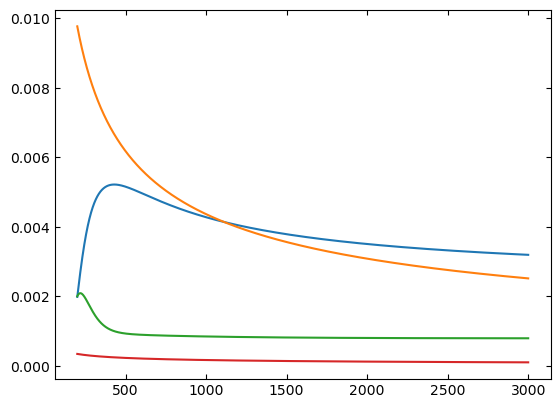

In [5]:
xs = np.linspace(200,3000, 10000)
plt.plot(xs, G1eff(xs))
plt.plot(xs, G2eff(xs))
plt.plot(xs, G1err(xs))
plt.plot(xs, G2err(xs))
#plt.ylim(0,0.06)

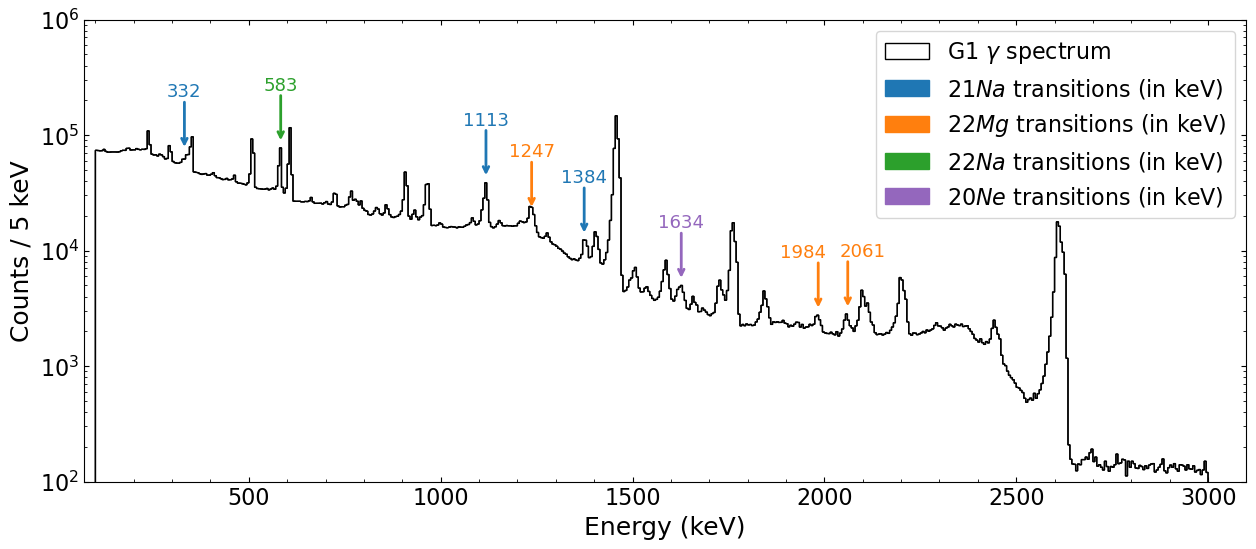

In [18]:
plt.figure(figsize=(15,6))
counts, bins, _ = plt.hist(Eg1, bins=np.arange(0,3000+5,5), histtype='step', color='k', label=r"G1 $\gamma$ spectrum")
plt.xlabel("Energy (keV)", fontsize=18)
plt.ylabel("Counts / 5 keV", fontsize=18)
plt.yscale('log')
plt.xticks(np.arange(0,3500,500), fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(70,3100)
plt.ylim(100,1e6)
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(100))
# --- Helper: find peak height near given energy ---
def peak_height(energy, bins, counts, window=10):
    idx = (bins[:-1] >= energy-window) & (bins[:-1] <= energy+window)
    if np.any(idx):
        return np.max(counts[idx])
    return 1e3  # fallback if nothing found
# --- Arrow lists and colors ---
peaks = {
    "21Na": ([332,1113,1384], "tab:blue"),
    "22Mg": ([1247,1984,2061], "tab:orange"),
    "22Na": ([583], "tab:green"),
    "20Ne": ([1634], "tab:purple")  # new transition added
}
# Draw arrows and energy labels
for isotope, (energies, color) in peaks.items():
    for i, e in enumerate(energies):
        ypeak = peak_height(e, bins, counts)
        ytop = ypeak*3  # top of arrow
        # Slight horizontal offset for labels if needed
        offset = 0
        p_offset = 0
        if isotope == "22Mg":  # offset the last two peaks to avoid overlap
            if i == 1:  # 1985
                offset = -40
            elif i == 2:  # 2061
                offset = +40
            elif i==0:
                p_offset= -10
        elif isotope == "21Na":
            if i == 1:
                p_offset = +5
            elif i == 2:
                p_offset = -10 
        elif isotope == "20Ne":
            p_offset = -7
        plt.annotate("", xy=(e+p_offset, ypeak*1.1), xytext=(e+p_offset, ytop),
                     arrowprops=dict(arrowstyle="->", color=color, lw=2))
        plt.text(e+offset+p_offset, ytop*1.05, f"{e}", color=color, fontsize=13, ha="center")

# Add a legend-like text box for isotopes
from matplotlib.patches import Patch
patches = [Patch(facecolor=color, edgecolor=color, label=fr"${iso}$ transitions (in keV)")
           for iso, (_, color) in peaks.items()]
hist_handle = plt.hist(Eg1, bins=np.arange(0,3000+5,5), histtype='step', color='k', label=r"G1 $\gamma$ spectrum")[2][0]
handles = [hist_handle] + patches
plt.legend(handles=handles, fontsize=16, loc="upper right")
plt.savefig("G1spec.pdf")


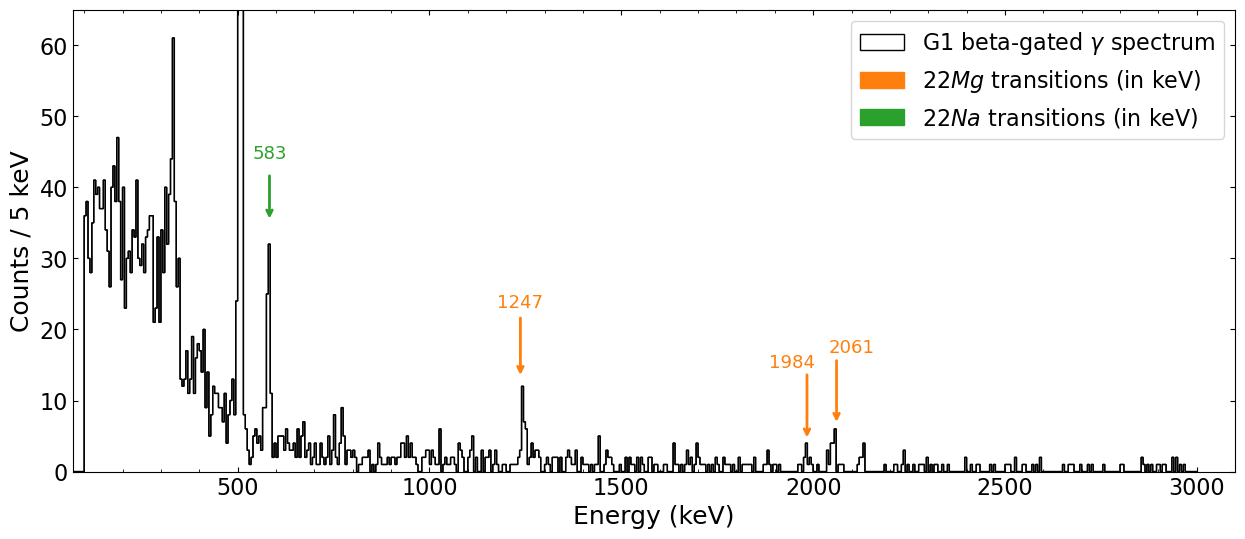

In [16]:
plt.figure(figsize=(15,6))
counts, bins, _ = plt.hist(Egs1, bins=np.arange(0,3000+5,5), histtype='step', color='k', label=r"G1 beta-$\gamma$ spectrum")
plt.xlabel("Energy (keV)", fontsize=18)
plt.ylabel("Counts / 5 keV", fontsize=18)
#plt.yscale('log')
plt.xticks(np.arange(0,3500,500), fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(70,3100)
plt.ylim(0,65)
plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(100))

def peak_height(energy, bins, counts, window=10):
    idx = (bins[:-1] >= energy-window) & (bins[:-1] <= energy+window)
    if np.any(idx):
        return np.max(counts[idx])
    return 1e3  # fallback if nothing found
# --- Arrow lists and colors ---
peaks = {
    "22Mg": ([1247,1984,2061], "tab:orange"),
    "22Na": ([583], "tab:green")

}
# Draw arrows and energy labels
for isotope, (energies, color) in peaks.items():
    for i, e in enumerate(energies):
        ypeak = peak_height(e, bins, counts)
        ytop = ypeak+10  # top of arrow
        # Slight horizontal offset for labels if needed
        offset = 0
        p_offset = 0
        if isotope == "22Mg":  # offset the last two peaks to avoid overlap
            if i == 1:  # 1985
                offset = -40
            elif i == 2:  # 2061
                offset = +40
            elif i==0:
                p_offset= -10
            
        plt.annotate("", xy=(e+p_offset, ypeak*1.1), xytext=(e+p_offset, ytop),
                     arrowprops=dict(arrowstyle="->", color=color, lw=2))
        plt.text(e+offset+p_offset, ytop*1.05, f"{e}", color=color, fontsize=13, ha="center")

# Add a legend-like text box for isotopes
from matplotlib.patches import Patch
patches = [Patch(facecolor=color, edgecolor=color, label=fr"${iso}$ transitions (in keV)")
           for iso, (_, color) in peaks.items()]
hist_handle = plt.hist(Egs1, bins=np.arange(0,3000+5,5), histtype='step', color='k', label=r"G1 beta-gated $\gamma$ spectrum")[2][0]
handles = [hist_handle] + patches
plt.legend(handles=handles, fontsize=16, loc="upper right")
plt.savefig("G1betagated.pdf")

G1 --> [59.5, 25.0, 12.0, 21.0]
G2 --> [65.50000000000001, 34.0, 12.0, 14.0]


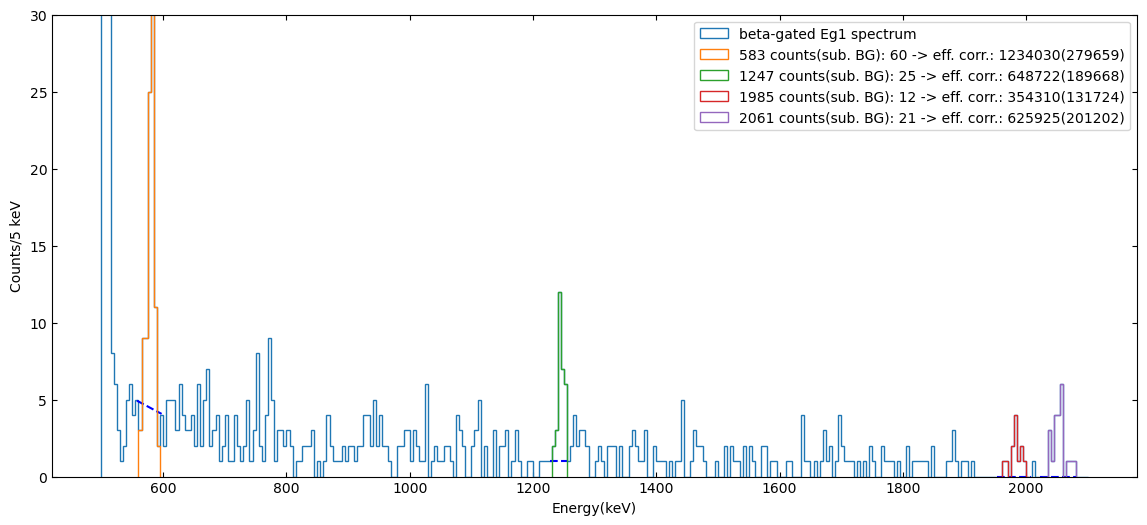

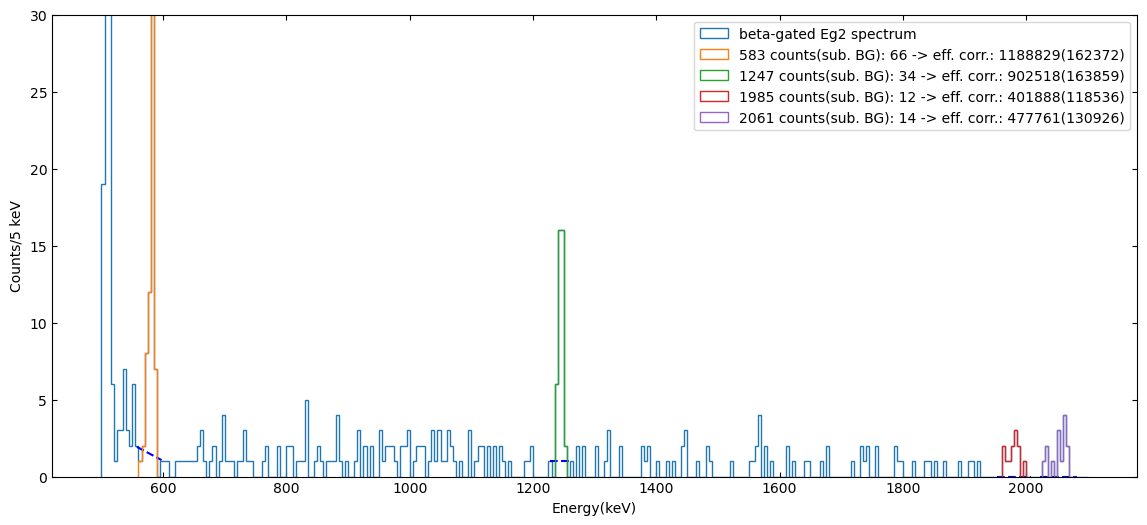

In [8]:

lowlims = [(560,560),(1230,1230),(1955,1955),(2025,2025)]
uplims = [(595,595),(1255,1260),(2005,2005),(2080,2080)]
bw = 5
es = [Egs1, Egs2]
ps = [583,1247,1985,2061]
i=0
beff = 0.00964
beff_err = 0.00042
for e in es:
    counts = []
    plt.figure(figsize=(14,6))
    plt.hist(e, bins=np.arange(500,2100+bw, bw), histtype='step', label=f"beta-gated Eg{i+1} spectrum")
    for l,u,p in zip(lowlims,uplims,ps):
        if i==0:
            eff = G1eff(p)
            eff_err = G1err(p)
        if i==1:
            eff = G2eff(p)
            eff_err = G2err(p)
        ys, xs = np.histogram(e, bins=np.arange(l[i],u[i]+5,5))
        
        bin_centers = ((xs[:-1] + xs[1:]) / 2)
        left_bin = np.histogram(e, [l[i]-5, l[i]])[0][0]
        right_bin = np.histogram(e, [u[i], u[i]+5])[0][0]
        bg = np.interp(bin_centers, np.array([l[i], u[i]]), np.array([left_bin,right_bin]))
        sc = np.sum(ys - bg)
        counts.append(sc)
        xbg = np.linspace(bin_centers[0]-5, bin_centers[-1]+5, len(bg))
        plt.plot(xbg, np.array(bg), color='b', ls='--')
        truec_err=np.sqrt((1/(eff*beff))**2*sc+(sc/(eff**2*beff))**2*eff_err**2+(sc/(eff*beff**2))**2*beff_err**2)
        plt.hist(e, bins=np.arange(l[i],u[i]+5,5), histtype='step', label=f"{p} counts(sub. BG): {sc:.0f} -> eff. corr.: {sc*1/eff*1/beff:.0f}({truec_err:.0f})")
        plt.legend(loc='upper right')
    plt.yscale('linear')
    plt.ylim(0,30)
    plt.xlabel("Energy(keV)")
    plt.ylabel("Counts/5 keV")
    i+=1
    print(f"G{i} --> {counts}")
    #plt.savefig(f"G{i}withcut.pdf")

    

In [11]:
weighted_mean([902518,648722], [162372,189668]), weighted_mean([401888,354310], [118536,131724]), weighted_mean([477761, 625925], [130926,201202])

((795180.8912593648, 125381.31414664349),
 (380599.2838656011, 88112.3034502392),
 (521835.98059350945, 109737.99251219898))